In [95]:
# Import the pacakges 
# 
import torch
from torch.utils.data import DataLoader, random_split
import os
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
# Import internal functions 

from unet_2 import UNet_2
from utils.data_loading_2 import CarvanaDataset_2
from evaluate_2 import evaluate_2

In [96]:
# The path of data and model 

dir_model = 'Z:/Dongyu Fan/2. Data/ImageProcessing/training/2024-10-07/10-07_17-14/model_checkpoint_epoch_3.pth'
dir_img = 'Z:/Dongyu Fan/2. Data/ImageProcessing/Simulation/2024-10-07/12-19/img/'
dir_mask = 'Z:/Dongyu Fan/2. Data/ImageProcessing/Simulation/2024-10-07/12-19/mask/'
dir_D = 'Z:/Dongyu Fan/2. Data/ImageProcessing/Simulation/2024-10-07/12-19/Diffusion/'

In [97]:
def post_evaluation(model, val_loader):

    diffusion_pair = []
    for batch in val_loader:
        img, mask_true, D_true = batch['image'], batch['mask'], batch['D']
        mask_pred, D_pred = model(img)
        binary_mask = (torch.sigmoid(mask_pred) >= 0.5).float()
        true_results = (mask_true.float() * D_true).flatten().tolist()
        pred_results = (binary_mask * D_pred).flatten().tolist()
        pairs = [(a,b) for a,b in zip(true_results, pred_results) if a * b != 0]
        diffusion_pair.extend(pairs)

    return diffusion_pair
        



In [98]:
# 1. load the model 
# Initialize the model 
model = UNet_2(n_channels=1, n_classes=1,bilinear=False)
# Load the saved state_dict
model.load_state_dict(torch.load(dir_model,map_location=torch.device('cpu') ))
# Set to evaluation mode
model.eval()

# 2. Prepare the data loader 
# Prepare for the data set 
dataset = CarvanaDataset_2(dir_img, dir_mask, dir_D)
#Split into train / validation partitions. Using the same seed used in training 
n_val = int(len(dataset) * 0.1)
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0)) 

loader_args = dict(batch_size=1, num_workers=os.cpu_count(), pin_memory=True)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

# 3.  Perform evaluation
# Set up the device: 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mask_loss, diffusion_loss = evaluate_2(model,val_loader,device,amp=False)
diffusion_pair = post_evaluation(model, val_loader)





KeyboardInterrupt: 

In [113]:
def scatter_with_gaussian_kde( pair, s):

    array = np.array(pair)
    xy = np.vstack(array).T
    z = gaussian_kde(xy)(xy)

    plt.scatter( *zip(*pair),c = z, s = s)
    plt.ylim([0,1])

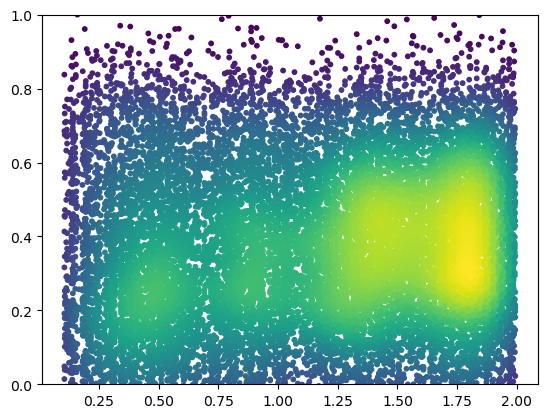

In [114]:
scatter_with_gaussian_kde(diffusion_pair,10)

array([[ 3.03021479,  0.37468547],
       [ 3.03021479,  0.54216295],
       [ 3.03021479,  0.34342477],
       ...,
       [ 3.41241503, -0.41730779],
       [ 3.41241503,  0.05365621],
       [ 3.41241503, -0.23510557]])

(0.0, 1.0)

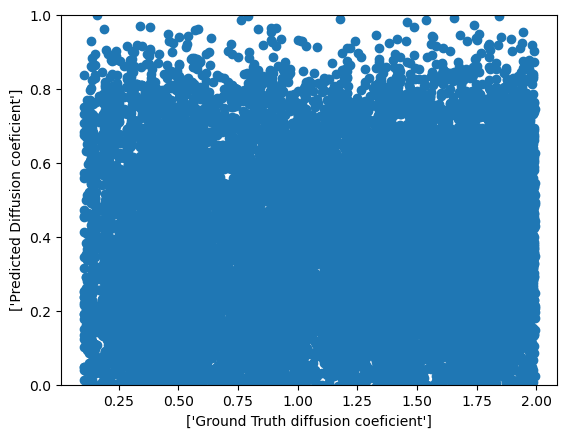

In [79]:
# 4. Visualize the results 
plt.scatter(*zip(*diffusion_pair))
plt.xlabel(['Ground Truth diffusion coeficient'])
plt.ylabel(['Predicted Diffusion coeficient'])
plt.ylim([0,1])